In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        vc = data.loc[data['set'] == set_num, col].value_counts()
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,92.76%,7.24%
validation set - fold 0,92.76%,7.24%
development set - fold 1,92.76%,7.24%
validation set - fold 1,92.76%,7.24%
development set - fold 2,92.76%,7.24%
validation set - fold 2,92.76%,7.24%
development set - fold 3,92.76%,7.24%
validation set - fold 3,92.76%,7.24%
development set - fold 4,92.76%,7.24%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

66
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'cate

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0425774
[100]	valid_0's binary_logloss: 0.0400447
[150]	valid_0's binary_logloss: 0.0388366
[200]	valid_0's binary_logloss: 0.0381382
[250]	valid_0's binary_logloss: 0.0376346
[300]	valid_0's binary_logloss: 0.0372854
[350]	valid_0's binary_logloss: 0.0368611
[400]	valid_0's binary_logloss: 0.0364991
[450]	valid_0's binary_logloss: 0.0362258
[500]	valid_0's binary_logloss: 0.0359198
[550]	valid_0's binary_logloss: 0.0356812
[600]	valid_0's binary_logloss: 0.0354347
[650]	valid_0's binary_logloss: 0.0352144
[700]	valid_0's binary_logloss: 0.0350228
[750]	valid_0's binary_logloss: 0.0348223
[800]	valid_0's binary_logloss: 0.0346211
[850]	valid_0's binary_logloss: 0.0344185
[900]	valid_0's binary_logloss: 0.034272
[950]	valid_0's binary_logloss: 0.0341216
[1000]	valid_0's binary_logloss: 0.0339775
[1050]	valid_0's binary_logloss: 0.0338322
[1100]	valid_0's binary_logloss: 0.0336842
[1150]	valid_0's binary_logloss: 0.0335601
[1200]	valid_0's binary_logloss:

In [ ]:
del train_data
gc.collect()

87

#Check Feature Importances

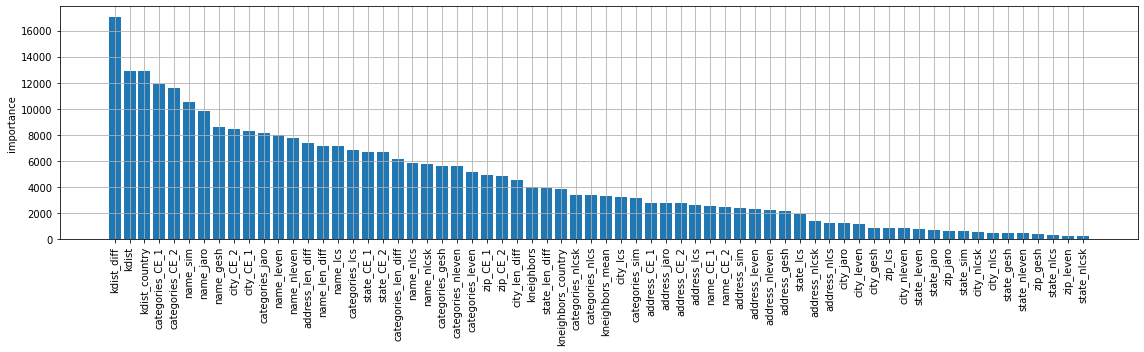

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-29 16:53:59,064] A new study created in memory with name: no-name-279ef86e-bd05-4a91-a942-07aedc9fc644
[I 2022-05-29 16:54:51,494] Trial 0 finished with value: 0.8208046394768916 and parameters: {'threshold': 0.2547517241076209}. Best is trial 0 with value: 0.8208046394768916.


CV: 0.820805


[I 2022-05-29 16:55:11,961] Trial 1 finished with value: 0.8357625727841642 and parameters: {'threshold': 0.5928911600715958}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835763


[I 2022-05-29 16:55:33,612] Trial 2 finished with value: 0.8320245480613 and parameters: {'threshold': 0.40866110135467415}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.832025


[I 2022-05-29 16:55:53,291] Trial 3 finished with value: 0.8305296436717061 and parameters: {'threshold': 0.7805100362432328}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.830530


[I 2022-05-29 16:56:13,799] Trial 4 finished with value: 0.8266639639586603 and parameters: {'threshold': 0.8284933407842605}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.826664


[I 2022-05-29 16:56:34,193] Trial 5 finished with value: 0.8325602861384945 and parameters: {'threshold': 0.42075140830177304}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.832560


[I 2022-05-29 16:56:55,188] Trial 6 finished with value: 0.8345877693231903 and parameters: {'threshold': 0.6911378634806999}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.834588


[I 2022-05-29 16:57:16,583] Trial 7 finished with value: 0.8353104028409114 and parameters: {'threshold': 0.5334676431823265}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835310


[I 2022-05-29 16:57:42,255] Trial 8 finished with value: 0.7912099488643917 and parameters: {'threshold': 0.11115798067189087}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.791210


[I 2022-05-29 16:58:03,724] Trial 9 finished with value: 0.8356307435581903 and parameters: {'threshold': 0.6291180912238089}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835631


[I 2022-05-29 16:58:23,607] Trial 10 finished with value: 0.8119048392237905 and parameters: {'threshold': 0.9145025046460801}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.811905


[I 2022-05-29 16:58:45,171] Trial 11 finished with value: 0.8357614010203791 and parameters: {'threshold': 0.608242997152057}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835761


[I 2022-05-29 16:59:05,756] Trial 12 finished with value: 0.8356840841577152 and parameters: {'threshold': 0.5609800681160058}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835684


[I 2022-05-29 16:59:27,123] Trial 13 finished with value: 0.8269997155030208 and parameters: {'threshold': 0.3223178506926366}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.827000


[I 2022-05-29 16:59:48,005] Trial 14 finished with value: 0.8336515848120233 and parameters: {'threshold': 0.7218501659998015}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.833652


[I 2022-05-29 17:00:16,583] Trial 15 finished with value: 0.5386370978150694 and parameters: {'threshold': 0.002944592576374916}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.538637


[I 2022-05-29 17:00:37,032] Trial 16 finished with value: 0.7891001060488674 and parameters: {'threshold': 0.965391328949903}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.789100


[I 2022-05-29 17:00:58,416] Trial 17 finished with value: 0.8344754348622954 and parameters: {'threshold': 0.4788486668482455}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.834475


[I 2022-05-29 17:01:18,755] Trial 18 finished with value: 0.8356298219107698 and parameters: {'threshold': 0.6274700116985499}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835630


[I 2022-05-29 17:01:43,601] Trial 19 finished with value: 0.8200773510371127 and parameters: {'threshold': 0.2488697079848018}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.820077


[I 2022-05-29 17:02:04,019] Trial 20 finished with value: 0.8236692045351447 and parameters: {'threshold': 0.8540436049616926}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.823669


[I 2022-05-29 17:02:25,618] Trial 21 finished with value: 0.8357334260781704 and parameters: {'threshold': 0.5685045080605273}. Best is trial 1 with value: 0.8357625727841642.


CV: 0.835733


[I 2022-05-29 17:02:47,449] Trial 22 finished with value: 0.8358175229391329 and parameters: {'threshold': 0.6017773546114196}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835818


[I 2022-05-29 17:03:07,985] Trial 23 finished with value: 0.8347811673708362 and parameters: {'threshold': 0.6831977451626322}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.834781


[I 2022-05-29 17:03:29,860] Trial 24 finished with value: 0.8330610117927052 and parameters: {'threshold': 0.4344429751588954}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.833061


[I 2022-05-29 17:03:50,968] Trial 25 finished with value: 0.8310637696786172 and parameters: {'threshold': 0.7707369008958546}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.831064


[I 2022-05-29 17:04:11,243] Trial 26 finished with value: 0.8353773987943122 and parameters: {'threshold': 0.6450880663441204}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835377


[I 2022-05-29 17:04:34,570] Trial 27 finished with value: 0.8348118889588153 and parameters: {'threshold': 0.4962815068989514}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.834812


[I 2022-05-29 17:05:04,060] Trial 28 finished with value: 0.8296878234340594 and parameters: {'threshold': 0.3640188302718407}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.829688


[I 2022-05-29 17:05:26,832] Trial 29 finished with value: 0.8192444636135494 and parameters: {'threshold': 0.24183823048154518}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.819244


[I 2022-05-29 17:05:48,946] Trial 30 finished with value: 0.8357574051968171 and parameters: {'threshold': 0.5888315933583583}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835757


[I 2022-05-29 17:06:10,595] Trial 31 finished with value: 0.835763900275988 and parameters: {'threshold': 0.5946456387831549}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835764


[I 2022-05-29 17:06:31,355] Trial 32 finished with value: 0.8348338421520906 and parameters: {'threshold': 0.4976222609328951}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.834834


[I 2022-05-29 17:06:52,874] Trial 33 finished with value: 0.8319206782755275 and parameters: {'threshold': 0.7570157216210351}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.831921


[I 2022-05-29 17:07:14,890] Trial 34 finished with value: 0.8357698482002296 and parameters: {'threshold': 0.6111033694844882}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835770


[I 2022-05-29 17:07:37,028] Trial 35 finished with value: 0.8341061950772282 and parameters: {'threshold': 0.706553462647483}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.834106


[I 2022-05-29 17:07:57,270] Trial 36 finished with value: 0.8284717217077643 and parameters: {'threshold': 0.8075735484981674}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.828472


[I 2022-05-29 17:08:19,852] Trial 37 finished with value: 0.8338373718988291 and parameters: {'threshold': 0.45802726650946196}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.833837


[I 2022-05-29 17:08:49,606] Trial 38 finished with value: 0.8296768752880531 and parameters: {'threshold': 0.3639626186500634}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.829677


[I 2022-05-29 17:09:12,091] Trial 39 finished with value: 0.8354216182919719 and parameters: {'threshold': 0.5464567359939909}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835422


[I 2022-05-29 17:09:33,971] Trial 40 finished with value: 0.8352939037628759 and parameters: {'threshold': 0.5312194956120753}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835294


[I 2022-05-29 17:09:54,621] Trial 41 finished with value: 0.8355879019163037 and parameters: {'threshold': 0.6327891550355411}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835588


[I 2022-05-29 17:10:16,572] Trial 42 finished with value: 0.835816129003434 and parameters: {'threshold': 0.6027663070129271}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835816


[I 2022-05-29 17:10:38,368] Trial 43 finished with value: 0.8348648649928672 and parameters: {'threshold': 0.678473559505782}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.834865


[I 2022-05-29 17:10:58,980] Trial 44 finished with value: 0.8329314396513279 and parameters: {'threshold': 0.7387406232801896}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.832931


[I 2022-05-29 17:11:21,054] Trial 45 finished with value: 0.8357554399822509 and parameters: {'threshold': 0.5891527348329381}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835755


[I 2022-05-29 17:11:43,884] Trial 46 finished with value: 0.8352653858895809 and parameters: {'threshold': 0.5269970880775547}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835265


[I 2022-05-29 17:12:05,296] Trial 47 finished with value: 0.8351551893385485 and parameters: {'threshold': 0.6616521500988073}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.835155


[I 2022-05-29 17:12:26,982] Trial 48 finished with value: 0.8240969804801892 and parameters: {'threshold': 0.850569302839285}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.824097


[I 2022-05-29 17:12:50,563] Trial 49 finished with value: 0.8308568973244573 and parameters: {'threshold': 0.385688591867697}. Best is trial 22 with value: 0.8358175229391329.


CV: 0.830857


[I 2022-05-29 17:13:13,909] Trial 50 finished with value: 0.8358231952509904 and parameters: {'threshold': 0.603014593573392}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835823


[I 2022-05-29 17:13:35,914] Trial 51 finished with value: 0.8357713396617593 and parameters: {'threshold': 0.5934950658358265}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835771


[I 2022-05-29 17:13:59,599] Trial 52 finished with value: 0.8358017682555043 and parameters: {'threshold': 0.6007981314194024}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835802


[I 2022-05-29 17:14:22,280] Trial 53 finished with value: 0.8356953313169958 and parameters: {'threshold': 0.6180035096003074}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835695


[I 2022-05-29 17:14:44,630] Trial 54 finished with value: 0.8355702684494412 and parameters: {'threshold': 0.5552207974741611}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835570


[I 2022-05-29 17:15:08,247] Trial 55 finished with value: 0.8340347835070666 and parameters: {'threshold': 0.7093503671676402}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834035


[I 2022-05-29 17:15:31,148] Trial 56 finished with value: 0.8336426237811841 and parameters: {'threshold': 0.45320347435351777}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.833643


[I 2022-05-29 17:15:53,468] Trial 57 finished with value: 0.8352794100210209 and parameters: {'threshold': 0.6562556247700486}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835279


[I 2022-05-29 17:16:14,558] Trial 58 finished with value: 0.8352059534611089 and parameters: {'threshold': 0.5194802928897861}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835206


[I 2022-05-29 17:16:36,571] Trial 59 finished with value: 0.8357067176523753 and parameters: {'threshold': 0.5738918332606683}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835707


[I 2022-05-29 17:16:58,485] Trial 60 finished with value: 0.8283118982676719 and parameters: {'threshold': 0.8096009446635295}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.828312


[I 2022-05-29 17:17:21,727] Trial 61 finished with value: 0.8357670437200769 and parameters: {'threshold': 0.5979400138929425}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835767


[I 2022-05-29 17:17:44,226] Trial 62 finished with value: 0.835723014148111 and parameters: {'threshold': 0.6157278156243602}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835723


[I 2022-05-29 17:18:06,703] Trial 63 finished with value: 0.834862197656336 and parameters: {'threshold': 0.6782482974976539}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834862


[I 2022-05-29 17:18:28,872] Trial 64 finished with value: 0.8353367654989023 and parameters: {'threshold': 0.6478199007412621}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835337


[I 2022-05-29 17:18:51,347] Trial 65 finished with value: 0.8345379887444189 and parameters: {'threshold': 0.4821594738644368}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834538


[I 2022-05-29 17:19:13,302] Trial 66 finished with value: 0.8330227847695603 and parameters: {'threshold': 0.736755225288604}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.833023


[I 2022-05-29 17:19:34,113] Trial 67 finished with value: 0.8357150989847102 and parameters: {'threshold': 0.5665623172637035}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835715


[I 2022-05-29 17:19:55,830] Trial 68 finished with value: 0.8357658195307263 and parameters: {'threshold': 0.6094137006717696}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835766


[I 2022-05-29 17:20:16,603] Trial 69 finished with value: 0.8348748537711376 and parameters: {'threshold': 0.49884264102589443}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834875


[I 2022-05-29 17:20:37,750] Trial 70 finished with value: 0.8346542759493784 and parameters: {'threshold': 0.6883247619688538}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834654


[I 2022-05-29 17:20:59,237] Trial 71 finished with value: 0.8357561739825483 and parameters: {'threshold': 0.611527331244465}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835756


[I 2022-05-29 17:21:20,956] Trial 72 finished with value: 0.8357664629159162 and parameters: {'threshold': 0.5869083926616132}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835766


[I 2022-05-29 17:21:43,047] Trial 73 finished with value: 0.8357107328059551 and parameters: {'threshold': 0.5779402277080405}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835711


[I 2022-05-29 17:22:03,967] Trial 74 finished with value: 0.8353441098056895 and parameters: {'threshold': 0.5400593120637516}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835344


[I 2022-05-29 17:22:25,315] Trial 75 finished with value: 0.8353871970109198 and parameters: {'threshold': 0.644890499921699}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835387


[I 2022-05-29 17:22:46,053] Trial 76 finished with value: 0.8350834147216287 and parameters: {'threshold': 0.5138660800657631}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835083


[I 2022-05-29 17:23:07,776] Trial 77 finished with value: 0.8355370734002834 and parameters: {'threshold': 0.5537234091441192}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835537


[I 2022-05-29 17:23:30,238] Trial 78 finished with value: 0.8123479475230051 and parameters: {'threshold': 0.19443379346743578}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.812348


[I 2022-05-29 17:23:50,852] Trial 79 finished with value: 0.8357733133482947 and parameters: {'threshold': 0.5851579694559733}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835773


[I 2022-05-29 17:24:12,699] Trial 80 finished with value: 0.8332490580827786 and parameters: {'threshold': 0.44130579030168804}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.833249


[I 2022-05-29 17:24:34,277] Trial 81 finished with value: 0.8357528521878508 and parameters: {'threshold': 0.5916724940675229}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835753


[I 2022-05-29 17:24:55,780] Trial 82 finished with value: 0.8356077303212707 and parameters: {'threshold': 0.6323727298299063}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835608


[I 2022-05-29 17:25:17,557] Trial 83 finished with value: 0.8350455847245134 and parameters: {'threshold': 0.6651129422058673}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835046


[I 2022-05-29 17:25:37,941] Trial 84 finished with value: 0.8342596259261233 and parameters: {'threshold': 0.7024678963561384}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834260


[I 2022-05-29 17:26:00,024] Trial 85 finished with value: 0.8357552936303929 and parameters: {'threshold': 0.5891466590673925}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835755


[I 2022-05-29 17:26:20,783] Trial 86 finished with value: 0.8341608710029068 and parameters: {'threshold': 0.46890522897737147}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834161


[I 2022-05-29 17:26:42,602] Trial 87 finished with value: 0.8319778248303834 and parameters: {'threshold': 0.40776774534902804}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.831978


[I 2022-05-29 17:27:04,484] Trial 88 finished with value: 0.8356822659240452 and parameters: {'threshold': 0.5626809958050947}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835682


[I 2022-05-29 17:27:29,959] Trial 89 finished with value: 0.6788931430481425 and parameters: {'threshold': 0.01590856182293887}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.678893


[I 2022-05-29 17:27:51,650] Trial 90 finished with value: 0.8355892593557925 and parameters: {'threshold': 0.6330344792595979}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835589


[I 2022-05-29 17:28:18,070] Trial 91 finished with value: 0.8357934459047149 and parameters: {'threshold': 0.6051032754762242}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835793


[I 2022-05-29 17:28:41,048] Trial 92 finished with value: 0.835341984659337 and parameters: {'threshold': 0.5400274673033992}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835342


[I 2022-05-29 17:29:03,450] Trial 93 finished with value: 0.8358226720617018 and parameters: {'threshold': 0.6020694740503478}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835823


[I 2022-05-29 17:29:24,600] Trial 94 finished with value: 0.8357526401323024 and parameters: {'threshold': 0.6078033395003706}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835753


[I 2022-05-29 17:29:47,134] Trial 95 finished with value: 0.8349925386690106 and parameters: {'threshold': 0.6684184156664911}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.834993


[I 2022-05-29 17:30:09,176] Trial 96 finished with value: 0.8355868285793385 and parameters: {'threshold': 0.631933032456384}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835587


[I 2022-05-29 17:30:30,404] Trial 97 finished with value: 0.8335945819319394 and parameters: {'threshold': 0.7227159060648555}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.833595


[I 2022-05-29 17:30:53,303] Trial 98 finished with value: 0.8352833259605569 and parameters: {'threshold': 0.529990073579653}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835283


[I 2022-05-29 17:31:16,025] Trial 99 finished with value: 0.8350087848968698 and parameters: {'threshold': 0.5061436371520134}. Best is trial 50 with value: 0.8358231952509904.


CV: 0.835009


In [ ]:
threshold = study.best_params['threshold']
threshold

0.603014593573392

In [ ]:
study.best_value

0.8358231952509904

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.835823


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,142423.000000,142423.000000,138018.000000,138018.000000,132379.000000,146741.000000,146741.0,146741.000000,146741.000000,146741.000000,...,110494.000000,110494.000000,110494.000000,125387.000000,125605.000000,146741.000000,110494.000000,110494.000000,110494.000000,1.467410e+05
mean,0.007420,6.231866,0.003432,6.256488,0.423469,6.526550,1.0,0.269839,0.412765,16.525327,...,12.180109,0.682341,9.052926,2794.828890,2801.638557,8.928514,0.525966,0.590557,0.591258,1.955503e-01
std,0.068295,5.238917,0.022896,5.248633,2.387585,5.302693,0.0,0.299777,0.249367,9.420321,...,11.528500,0.244465,7.208964,3347.153628,3347.818981,10.888404,0.357201,0.331772,0.331249,1.887107e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.454472e-12
25%,0.000440,2.000000,0.000330,2.000000,0.006230,2.000000,1.0,0.000000,0.210526,10.000000,...,0.000000,0.485185,4.000000,413.000000,418.000000,0.000000,0.000000,0.285714,0.285714,2.331818e-02
50%,0.001098,4.000000,0.000845,4.000000,0.057257,5.000000,1.0,0.184029,0.400000,15.000000,...,11.000000,0.590943,7.000000,1441.000000,1447.000000,6.000000,0.709677,0.500000,0.500000,1.304136e-01
75%,0.003009,10.000000,0.002318,10.000000,0.316421,10.000000,1.0,0.498031,0.590909,22.000000,...,17.000000,1.000000,12.000000,3432.000000,3572.000000,13.000000,0.818182,1.000000,1.000000,3.457358e-01
max,4.448372,19.000000,2.388985,19.000000,214.206825,19.000000,1.0,1.000000,1.000000,59.000000,...,87.000000,1.000000,77.000000,12545.000000,12545.000000,90.000000,1.000000,1.000000,1.000000,6.030105e-01


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
1190355,E_171e5ec5ead304,E_80bbb045bd56e1,0.000127,2.0,P_1c212c34882fb5,0.000127,2.0,1.786624e-03,2.0,1,...,12.0,0.564815,4.0,5929.0,1590.0,7,0.750000,0.250000,0.444444,0.458087
10828489,E_0465e40bc779ea,E_703fcdeae7faeb,0.006305,19.0,P_35b1ccdce2f1cb,0.004717,15.0,3.367465e-01,17.0,1,...,NaN,NaN,NaN,NaN,3205.0,4,NaN,NaN,NaN,0.137050
1898506,E_5569cdc92694e8,E_6b583d57377dfc,0.006446,3.0,P_6c385e5fd3a4b7,0.006279,3.0,2.667105e-02,3.0,1,...,NaN,NaN,NaN,1.0,NaN,30,NaN,NaN,NaN,0.007503
3018129,E_4cd32325e1b2a7,E_e863517a0af0ec,0.001980,5.0,P_13df291010366b,0.001978,5.0,8.306778e-04,5.0,1,...,20.0,0.880877,23.0,8.0,1.0,12,0.487805,0.560976,0.793103,0.155294
2243997,E_f0c3b4667474b2,E_5c1b79149c5c1b,0.000178,3.0,P_ebf6d4a6b3f293,0.000171,3.0,3.818078e-02,3.0,1,...,33.0,0.511860,20.0,1882.0,2.0,33,0.622642,0.377358,1.000000,0.076882
731738,E_48e9bff75f8857,E_4709fb54e5020c,0.000338,1.0,P_384d77d5a326ec,0.000334,1.0,1.400574e-02,1.0,1,...,9.0,0.598693,9.0,275.0,2342.0,2,0.529412,0.600000,0.529412,0.163956
810742,E_6c5a2096ce4548,E_7059410bcf374b,0.001119,1.0,P_832f40b65b1614,0.001101,1.0,1.702068e-02,1.0,1,...,12.0,0.306349,3.0,659.0,3205.0,8,0.800000,0.428571,0.200000,0.190058
1401386,E_75ded9c4870875,E_b2390ae02f2fd1,0.000303,2.0,P_c319d7677eb6b5,0.000288,5.0,4.999680e-02,3.5,1,...,13.0,0.444444,5.0,2395.0,10692.0,6,0.722222,0.277778,0.416667,0.082668
11246751,E_c03311a7daf40b,E_dc33c67225b1e5,0.000652,19.0,P_78d12fbd779203,0.000622,19.0,4.826489e-02,19.0,1,...,NaN,NaN,NaN,10692.0,NaN,15,NaN,NaN,NaN,0.572511
1806721,E_2c1e4be0455714,E_e94538baa8a718,0.001493,3.0,P_1729b713cfe7c7,0.001430,3.0,4.348343e-02,3.0,1,...,19.0,0.907317,22.0,92.0,1513.0,19,0.463415,1.000000,0.536585,0.193059


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
333093,E_4adfd5df02459b,Beet Peruvian restaurant,4.173118,73.511303,NaN,NaN,NaN,NaN,MV,NaN,NaN,Peruvian Restaurants,P_54ab4b90db0a60,4,1.0
1037400,E_e9127a4e41ac8d,Beet military,4.172914,73.511376,NaN,NaN,NaN,NaN,MV,NaN,NaN,Military Bases,P_54ab4b90db0a60,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
205338,E_2e1498b58148c5,地铁梅花园站 - Meihuayuan Metro Station,23.178512,113.315018,地铁三号线 - Metro Line 3,Guangzhou,Guangdong,NaN,CN,NaN,NaN,Metro Stations,P_cbc134c879728e,1,1.0
637693,E_8f5c34e8dda310,Metro (卖德龙，白云区）,23.197290,113.258049,NaN,NaN,NaN,NaN,CN,NaN,NaN,NaN,P_cbc134c879728e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
204335,E_2dda773104d5a0,408 Музыка,55.685339,37.527047,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Academic Buildings,P_55d7d209ceaad4,4,1.0
413067,E_5ccf35dadd4b26,английский в 311,55.686481,37.526337,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_55d7d209ceaad4,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387441,E_57099b58e40d44,Microsoft Technology Center Burlington,42.483956,-71.191606,5 Wayside Rd,Burlington,MA,01803,US,NaN,NaN,Business Centers,P_2873e1afcbf977,2,1.0
838005,E_bc2fc9e6b8e7aa,Microsoft,42.484484,-71.190771,5 Wayside Rd,Burlington,MA,01803,US,http://www.microsoft.com,NaN,Offices,P_2873e1afcbf977,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
126033,E_1c3f381cd7debe,Unterschwarzachbahn - Flutlichtpiste,47.376800,12.594532,Schwarzacherweg 455,Hinterglemm,Salzburg,5754,AT,http://www.saalbach.com,NaN,"Ski Areas, Ski Chairlifts",P_0106ce160d814e,1,1.0
839325,E_bc7e480c0baea4,Nachtskilaufen Rreiterkogel,47.371412,12.597460,NaN,NaN,NaN,NaN,AT,NaN,NaN,Mountains,P_0106ce160d814e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
131063,E_1d61fa6996b121,Walmart Supercenter,26.207064,-80.223155,7900 W Mcnab Rd,North Lauderdale,FL,33068,US,https://www.walmart.com/store/1851/north-laude...,9547263388,"Big Box Stores, Supermarkets, Grocery Stores",P_93b3c5fff08388,4,1.0
389668,E_578baec156326d,New Walmart Under Construction,26.207740,-80.230647,7900 W McNab Rd,Fort Lauderdale,FL,33321,US,NaN,NaN,Department Stores,P_93b3c5fff08388,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
637852,E_8f651f8d02887a,Bank of the Philippine Islands (BPI),14.677946,121.08248,Commonwealth Ave cor Holy Spirit Dr,Quezon City,Metro Manila,1127,PH,https://www.bpi.com.ph,29310151,Banks,P_3c7ed78557d275,1,1.0
753060,E_a92654ee3489c6,Bank of the Philippine Islands Don Antonio Branch,14.678440,121.08244,NaN,NaN,NaN,NaN,PH,NaN,NaN,Banks,P_3c7ed78557d275,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
422344,E_5ee27deb5ae9f6,disFruta,-5.184625,-80.641731,NaN,Piura,NaN,NaN,PE,NaN,NaN,Juice Bars,P_cbec161f57509f,1,1.0
781704,E_af955209bb140b,D'frutas,-5.185885,-80.642296,NaN,Piura,Piura,NaN,PE,NaN,NaN,Juice Bars,P_cbec161f57509f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
759427,E_aa9ac5c5e1a4bf,Romanian Hungarian Border | Frontieră România ...,46.168059,20.714359,Nădlac - Nagylak,Nădlac / Nădlac,NaN,NaN,RO,https://www.politiadefrontiera.ro,NaN,Border Crossings,P_fe266ee7924f25,2,1.0
797468,E_b31b2028022c5f,Vama Nădlac,46.167854,20.719485,Str. Independenței,Nădlac,Arad,NaN,RO,http://politiadefrontiera.ro,+40257474593,Border Crossings,P_fe266ee7924f25,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
228052,E_332f08fe344fb8,гимназия №5,56.137061,47.243743,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_34c4f8aeaeda76,4,1.0
377268,E_54c2af2af4be00,Медпункт(Гимназия №5),56.138012,47.242806,NaN,NaN,NaN,NaN,RU,NaN,NaN,Middle Schools,P_34c4f8aeaeda76,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
517382,E_7449fd42acbdb8,Мат методы в экономике,47.225635,39.709844,Горького 88,NaN,NaN,NaN,RU,NaN,NaN,Universities,P_d24e553991baed,4,1.0
769388,E_acd041c8c1dd90,Юридическая клиника,47.225216,39.709675,Горького 88,NaN,NaN,NaN,RU,NaN,NaN,Law Schools,P_d24e553991baed,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
802077,E_b41dfbe37c2ebf,RSPP 357,-6.240225,106.793306,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_a13555e7b5e71f,4,1.0
872307,E_c3f011021eb93e,Depan RS Pertamina,-6.239721,106.794087,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_a13555e7b5e71f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
369594,E_5306cc89297d18,Hinode 제주신라호텔,33.245681,126.407830,노연로 69,NaN,NaN,NaN,KR,NaN,NaN,Sushi Restaurants,P_d3913fbcdacf36,2,1.0
972379,E_da6e285d453d50,히노데 (Hinode / 日の出),33.247288,126.408126,중문관광로72번길 75,서귀포시,제주특별자치도,63535,KR,http://www.shilla.net/jeju/dining/viewDining.d...,647355339,"Japanese Restaurants, Sushi Restaurants",P_d3913fbcdacf36,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
476362,E_6b0fa78f41c7ae,Урок у Курицы 🐔,60.028716,30.420021,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_78d12fbd779203,4,1.0
631096,E_8de6e91a0554d4,У Каркуши 💡,60.028834,30.419716,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Labs,P_78d12fbd779203,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
892197,E_c86c70898cfd77,4th Tee,33.783058,-84.326247,DHGC,Atlanta,GA,30307,US,NaN,NaN,Golf Courses,P_8c9be8e6945ced,4,1.0
915268,E_cd99afdc215c32,2nd Green,33.782061,-84.329255,Clifton Rd,Atlanta,GA,30307,US,NaN,NaN,Golf Courses,P_8c9be8e6945ced,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
260923,E_3a940e47404c5e,Corner House,-8.684488,115.164414,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_b40e91d8f099d7,1,1.0
988654,E_de1d62a5614bf0,CORNERHOUSE,-8.683475,115.164347,Jalan Laksmana,Seminyak,Bali,80361,ID,http://www.cornerhousebali.com,+62361730276,"Cafés, Breakfast Spots, Bars",P_b40e91d8f099d7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
155636,E_22ddf11c36712f,Bologna Fiere,44.511590,11.364850,Piazza della Costituzione 5,Bologna,BO,40128,IT,http://www.bolognafiere.it,051282111,Convention Centers,P_e1f3735806543e,4,1.0
476753,E_6b275cfa7da8b4,Lucco,44.507095,11.365563,NaN,Bolonya,NaN,40128,IT,NaN,NaN,Fairs,P_e1f3735806543e,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
372823,E_53c62f418f3fef,Kampung Cokelat Blitar,-8.156770,112.171756,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_639b2b83796da2,4,1.0
625053,E_8c8953fd393201,Wisata Edukatif Kampung Coklat,-8.155958,112.163826,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_639b2b83796da2,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195442,E_2bd9346e8489db,Barbro Bio Rio Salong 4,59.314428,18.033089,NaN,"Stockholm, Sweden",NaN,NaN,SE,NaN,NaN,NaN,P_d2dbf350a05656,1,1.0
652054,E_9284341340f592,Indio Cinema,59.315303,18.030504,Hornstulls strand 3,Stockholm,NaN,117 39,SE,https://cinema.indio.se,86699500,"Indie Movie Theaters, Bars, Japanese Restaurants",P_d2dbf350a05656,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
654772,E_9325b4e75df4a0,Bahia Lakes Pool,27.730367,-82.449328,956 Seminole Sky Dr,Ruskin,FL,33570,US,NaN,NaN,Pools,P_2cf44cb479bd19,2,1.0
717341,E_a1223e77120865,Bahia Lake,27.726850,-82.442393,NaN,Ruskin,FL,33570,US,NaN,NaN,Housing Developments,P_2cf44cb479bd19,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
571654,E_808141abd6f4bc,The Saint Augustine Beach House,29.916244,-81.324344,10 Vilano Rd,Saint Augustine,FL,32084,US,https://www.sabhonline.com,9042173765,"Hotels, Roof Decks, Waterfronts",P_1716a8389c94b1,2,1.0
1056677,E_ed742860ea8464,SABH Room 304 Balcony,29.917056,-81.290598,NaN,Villano Beach,FL,NaN,US,NaN,NaN,NaN,P_1716a8389c94b1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
791020,E_b1abb5c38c62a9,Shekarchi Restaurant,34.043203,-118.258575,920 S Olive St,Los Angeles,CA,90015,US,http://shekarchirestaurant.com,9147445578,"Middle Eastern Restaurants, Mediterranean Rest...",P_7151522116bca7,1,1.0
884180,E_c69585dc223dbc,Shekarchi Bar & Grill,34.043135,-118.258485,920 S Olive St,Los Angeles,CA,90015,US,NaN,NaN,Persian Restaurants,P_7151522116bca7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
825848,E_b972dc6d8fcc97,McDonald's,30.037562,31.216469,Messaha Sq,Dokki,Muḩāfaz̧at al Jīzah,NaN,EG,http://www.mcdonalds.eg,+2019991,Fast Food Restaurants,P_5bdf230013598e,2,1.0
841260,E_bcec8fd4bcb38b,McDonald's,30.035651,31.214043,10 El Mesaha Sq,Dokki,Muḩāfaz̧at al Jīzah,NaN,EG,http://www.mcdonalds.eg,19991,Fast Food Restaurants,P_5bdf230013598e,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
650114,E_9214f386ea7f1c,3 Этаж,47.225023,39.709774,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Residence Halls,P_d24e553991baed,4,1.0
699393,E_9d15c40345e983,Кафедра Международного права,47.225290,39.709615,Горького 88,NaN,NaN,NaN,RU,NaN,NaN,Law Schools,P_d24e553991baed,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
532742,E_77b9d71de97ce5,คณิตศาสตร์อ.อรรณนพ,13.758174,100.534580,Floor12,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_38b81f39a9895f,4,1.0
1128240,E_fd9ce7bededd3b,Annop Academic Achievement,13.757968,100.534613,Wannasorn Tower,NaN,NaN,NaN,TH,NaN,NaN,College Classrooms,P_38b81f39a9895f,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
178393,E_280768d1b730f0,修悦体,35.690909,139.699845,NaN,NaN,NaN,NaN,JP,NaN,NaN,Train Stations,P_fca69b372b3d66,4,1.0
574359,E_81199846db6952,JR 湘南新宿ライン 新宿駅,35.690565,139.699807,新宿3-38-1,新宿区,東京都,160-0023,JP,NaN,NaN,Train Stations,P_fca69b372b3d66,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
76653,E_1128ade0b03110,Belliago Hotel,36.111677,-115.173813,NaN,Las Vegas,NV,89109,US,NaN,NaN,"Hotels, Nightclubs, Casinos",P_bae8584591fe1a,4,1.0
473899,E_6a8127b009d4fd,Room 23037,36.110613,-115.175128,NaN,Las Vegas,NV,89109,US,NaN,NaN,Hotels,P_bae8584591fe1a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
704910,E_9e530ce02f6aca,Grove Park Inn Golf Course,35.619785,-82.547278,NaN,Asheville,NC,28804,US,NaN,NaN,Golf Courses,P_ee979310f5123d,4,1.0
1026159,E_e690da87b0c0ee,10th Green,35.620770,-82.543178,NaN,Asheville,NC,NaN,US,NaN,NaN,Golf Courses,P_ee979310f5123d,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
240731,E_360ad9aa81286e,XII IPA 5 SMA Negeri 7 Yogyakarta,-7.813796,110.359050,Jl. MT Haryono 47,Yogyakarta,NaN,NaN,ID,NaN,NaN,High Schools,P_c1b65b587e54cf,4,1.0
643211,E_9096e3994e89c2,Kelas XI IPA 3 SMAN 7 Yogyakarta (Ruang Bahasa 3),-7.814758,110.358229,NaN,NaN,NaN,NaN,ID,NaN,NaN,College Academic Buildings,P_c1b65b587e54cf,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
68221,E_0f43fd4e4a9682,МТС Банк,48.492564,135.081298,"Ленинградская,51",Хабаровск,NaN,NaN,RU,NaN,NaN,Banks,P_c70a7516b31a52,1,1.0
1094253,E_f5f1a46351f3d4,MTC Банк,48.492194,135.081110,"ул. Ленинградская, 51",Хабаровск,Хабаровский край,NaN,RU,NaN,8005552727,Banks,P_c70a7516b31a52,1,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,46714.000000,46714.000000,45528.000000,45528.000000,44397.000000,47351.000000,47351.0,47351.000000,47338.000000,47338.000000,...,37091.000000,37091.000000,37091.000000,41172.000000,41069.000000,47351.000000,37091.000000,37091.000000,37091.000000,47351.000000
mean,0.005276,4.503232,0.002622,4.528795,0.388801,4.707440,0.0,0.513597,0.596617,12.253264,...,10.009598,0.788745,11.509153,2643.878971,2628.668753,8.842939,0.368820,0.743409,0.744406,0.815912
std,0.103425,4.752600,0.010894,4.760581,1.737759,4.846509,0.0,0.342674,0.263376,9.378607,...,12.297556,0.239200,7.831891,3203.437629,3195.511160,11.914501,0.362905,0.322278,0.321577,0.122564
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.603019
25%,0.000285,1.000000,0.000224,1.000000,0.004870,1.000000,0.0,0.231908,0.416667,5.000000,...,0.000000,0.548181,6.000000,276.000000,281.000000,0.000000,0.000000,0.425266,0.428571,0.706386
50%,0.000802,2.000000,0.000624,2.000000,0.051137,2.000000,0.0,0.559446,0.619048,11.000000,...,7.000000,0.893333,11.000000,1356.000000,1350.000000,4.000000,0.400000,1.000000,1.000000,0.819440
75%,0.002584,6.000000,0.001965,6.000000,0.286290,7.000000,0.0,0.786973,0.800000,17.000000,...,16.000000,1.000000,15.000000,3572.000000,3572.000000,14.000000,0.743590,1.000000,1.000000,0.929828
max,11.519732,19.000000,0.684948,19.000000,94.986530,19.000000,0.0,1.000000,1.000000,58.000000,...,82.000000,1.000000,93.000000,12545.000000,12545.000000,90.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
708928,E_3e90efec962063,E_51fd881204896b,0.000408,1.0,P_57234baa2ab2c2,0.000407,1.0,0.000891,1.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.936404
4733046,E_4fd5dce1bfaedd,E_7900c42da5f8b0,0.002399,8.0,P_50583e801a6b5a,0.002356,8.0,0.018218,8.0,0,...,NaN,NaN,NaN,NaN,660.0,7,NaN,NaN,NaN,0.962243
1529517,E_af65d0ee766977,E_84e5c9323d8d3b,0.001495,2.0,P_44d79acc559379,0.001492,2.0,0.002399,2.0,0,...,23.0,0.532337,20.0,619.0,803.0,23,0.534884,1.000000,0.465116,0.895708
1830671,E_36dd23e1c3cb0e,E_0d3d3e662d7a28,0.002194,3.0,P_21f0a650c96a6e,0.002192,3.0,0.000919,3.0,0,...,21.0,0.832000,4.0,1.0,1026.0,21,0.840000,1.000000,0.160000,0.758758
1348327,E_5e18e3d9486457,E_e51bddbd9fb91f,0.000686,2.0,P_9a46bb36c8b4e4,0.000287,2.0,1.390752,2.0,0,...,0.0,1.000000,7.0,378.0,378.0,0,0.000000,1.000000,1.000000,0.859104
11277585,E_ce1a4cfa8a54ed,E_a48cb4530aa11f,0.000462,19.0,P_01e5c6b5c06e37,0.000424,16.0,0.088498,17.5,0,...,13.0,0.444444,5.0,2395.0,10692.0,6,0.722222,0.277778,0.416667,0.709613
6889737,E_197b455eaf35a3,E_5935feb023a650,0.001706,12.0,P_c55dd8aa053feb,0.001706,12.0,0.000065,12.0,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.605516
1076417,E_e3c226f6375bbc,E_d3c74979dc12e9,0.000077,1.0,P_492a1e51487c56,0.000077,1.0,0.005217,1.0,0,...,0.0,1.000000,5.0,10712.0,10712.0,0,0.000000,1.000000,1.000000,0.802289
3458877,E_13063966d93cac,E_18caf80d04d848,0.005001,6.0,P_0f4d58f69509ce,0.003857,5.0,0.296677,5.5,0,...,0.0,1.000000,20.0,5866.0,5866.0,0,0.000000,1.000000,1.000000,0.926692
5986928,E_8388384106b0c9,E_79b9c31ee0e8b9,0.000493,10.0,P_8cb7596c6a29a1,0.000483,10.0,0.021575,10.0,0,...,0.0,1.000000,11.0,956.0,956.0,0,0.000000,1.000000,1.000000,0.844583


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
901411,E_ca79740ccdb03c,Restoran anjung keli,6.411872,100.216836,Jalan taman desa pulai 1,Kangar,Perlis,NaN,MY,NaN,NaN,Malay Restaurants,P_b1e2eba1330a40,1,1.0
1085585,E_f3eff2fc615f6f,Nasi Kandar Abg Hensem,6.413638,100.200699,NaN,NaN,NaN,NaN,MY,NaN,NaN,Malay Restaurants,P_fe5633592a7e70,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
954536,E_d66f2e5e4b2895,Bakmi Ayam & Chinese Food AKAI,-8.679512,115.204197,Jalan Teuku Umar No. 186,Denpasar,Bali,NaN,ID,NaN,361235888,"Noodle Houses, Chinese Restaurants, Asian Rest...",P_85acc655bda24e,1,1.0
1070056,E_f07d121139de5b,Mie Akai,-8.679492,115.204116,Teuku umar,Denpasar,NaN,NaN,ID,NaN,NaN,Chinese Restaurants,P_863d6ffe003e8f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
384552,E_5665fbda1f1395,OWG Genting Highlands Premium Outlets,3.403501,101.78323,NaN,Genting Highlands,Pahang,69000,MY,NaN,NaN,Food Courts,P_e045fcb2e65e2a,0,1.0
662784,E_94ea55e543bc40,Genting Highlands Premium Outlets,3.403382,101.78146,NaN,云顶高原,彭亨,69000,MY,NaN,NaN,Outlet Malls,P_5614966fdd39dc,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
700976,E_9d6df755983afb,Y-London (Ramstore Mall),41.991571,21.427889,NaN,Skopje,Opština Karpoš,1000,MK,NaN,NaN,"Women's Stores, Boutiques",P_5918bc51d09afc,0,1.0
991816,E_decd2727d70f9f,Lacoste (Ramstore Mall),41.991836,21.427510,NaN,Skopje,NaN,NaN,MK,NaN,NaN,Boutiques,P_de4dd58cd2bccb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89888,E_142549f330ea28,Стоматологическая поликлиника № 11,59.852336,30.279940,"Ленинский просп., 138/5",город Санкт-Петербург,город Санкт-Петербург,198216,RU,http://stom11.ru,8123773805,Dentist's Offices,P_630a5ec839f91b,0,1.0
724673,E_a2c7a81e481c77,Городская Стомотологическая Поликлиника 33,59.852683,30.280187,Ленинский Пр. 178,Санкт- Петербург,NaN,NaN,RU,NaN,NaN,Dentist's Offices,P_aff0c3d4b3d776,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
221909,E_31d6d480be4d1a,70 Anson Road,1.274290,103.844641,NaN,NaN,NaN,NaN,SG,NaN,NaN,Buildings,P_3f53504d2f2360,0,1.0
595834,E_85ecf95086b8b3,Anson House,1.273754,103.844482,72 Anson Rd,Singapore,Singapore,079911,SG,NaN,64380921,"Offices, Buildings",P_469c87d9fd539c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
637244,E_8f437ff69a2a80,Aston Waikola Colony Villas,19.925111,-155.876830,69-555 Waikoloa Beach Dr,Waikoloa,HI,96738,US,https://www.aquaaston.com/hotels/aston-waikolo...,+18779976667,Hotels,P_8c45826f26a182,1,1.0
848060,E_be73f5a7364cbb,403 Waikoloa Colony Villas,19.926039,-155.879675,69-555 Waikoloa Beach Dr.,Waikoloa Village,HI,96738,US,NaN,NaN,Vacation Rentals,P_e13f53865da873,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
668490,E_962aea7b060720,Ruang J14 310 Departemen Teknik Industri USU,3.561614,98.655708,Gedung J14 Lt.3 R.10 Fakultas Teknik USU,Medan,North Sumatera,20115,ID,NaN,NaN,College Classrooms,P_bd52fe3b0d7cf7,0,1.0
706274,E_9ea26455990c9f,Ruang 1314 FT USU,3.561587,98.655802,Fakultas Teknik,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_d760641cc53e6e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
806620,E_b523fcc8b779f2,Fitness Room,13.778933,100.574398,NaN,Huai Khwang,Bangkok,10310,TH,NaN,NaN,Gyms or Fitness Centers,P_ef1b3ef155f06e,0,1.0
820835,E_b854f960bb1746,Fitness Room,13.777261,100.574224,Rhythm Ratchada-huaikhwang,NaN,NaN,NaN,TH,NaN,NaN,Climbing Gyms,P_aff0787fe79416,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
185057,E_298457dd2366bd,Jl KHA Dahlan No 1472,-2.986451,104.747027,NaN,Palembang,South Sumatra,30135,ID,NaN,NaN,NaN,P_bcce2c60b2df94,0,1.0
716105,E_a0db56d93d546b,Jl. KHA. Dahlan No 72,-2.983737,104.744581,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ee7156360ff03b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
763214,E_ab71b1401ab011,Tay Cam 3,-37.781476,144.920243,NaN,Ascot Vale,VIC,NaN,AU,NaN,NaN,Diners,P_28a4e1e8f1c40e,0,1.0
790968,E_b1a8e5f0651b08,Tay Cam 8,-37.781461,144.920519,NaN,NaN,NaN,NaN,AU,NaN,NaN,Diners,P_d1bd8e64b39286,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
350596,E_4ec8cc73a2e3e0,Al Vecchio Bivio,41.793174,12.667785,"Viale San Nilo, 103",Grottaferrata,Italia,NaN,IT,NaN,NaN,Pizza Places,P_fec8022c80622a,0,1.0
382115,E_55d9a3c54248ee,Ristorante da Valerio,41.787025,12.666904,"Viale S. Nilo, 3",Grottaferrata,RM,00046,IT,https://www.ristorantedavalerio.it,+39069410319,"Restaurants, Pizza Places, Convention Centers",P_a027f99a4cb06b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
233990,E_348491b1ce883c,Pantai Baru,-7.988758,110.220786,Serandakan,Bantul,Special Region of Yogyakarta,NaN,ID,NaN,NaN,"Beaches, Surf Spots, Nudist Beaches",P_d52413db90ff75,2,1.0
692677,E_9b962708cfe908,Pantai Baru,-7.961109,110.227101,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_ab2014e2f34cc5,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642834,E_90808e2b332d77,Club Social Los Milanos,37.404222,-5.941840,"C. Milano Govinda, 2",Sevilla,Sevilla,41020,ES,NaN,954672249,Bars,P_011e4c097896e6,0,1.0
665258,E_9577119cde600e,Club Social Los Mirtos,37.405525,-5.941125,Calle Senserina,Sevilla,NaN,41020,ES,NaN,NaN,Breweries,P_4967d705fc9ff5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
707950,E_9f037465341ec6,Sovereign Hill,-37.578426,143.865151,Bradshaw St,Ballarat,VIC,3350,AU,http://www.sovereignhill.com.au,353371100,Historic Sites,P_c92d722455c00a,0,1.0
922175,E_cf2778d18d930d,Sovereign Cafe,-37.575903,143.865162,NaN,NaN,NaN,NaN,AU,NaN,NaN,Cafés,P_b11489c972f60a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
308079,E_453544f6cce245,Starbucks Target,33.603769,-117.173713,NaN,Murrieta,CA,NaN,US,NaN,NaN,Coffee Shops,P_d2488cbfa1a73b,0,1.0
989499,E_de4c5142f1f9cf,Target,33.603820,-117.173598,27818 Clinton Keith Rd,Murrieta,CA,92562,US,https://www.target.com/sl/murrieta-north/2499,9517041123,"Big Box Stores, Department Stores",P_350c4538067ac1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
392257,E_581f9c75881057,Carpark 9,-35.028983,138.571319,Biological Sciences Rd,Bedford Park,SA,5042,AU,NaN,NaN,Parking,P_15dc5a2335a8fc,0,1.0
882922,E_c64fd8ae1856ed,Carpark 5,-35.025628,138.571349,Flinders University,NaN,NaN,NaN,AU,NaN,NaN,Parking,P_0f9fbc0993de8f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
925346,E_cfdabd18166270,Dharmawangsa kitchen!!,-6.254108,106.804406,Jl.brawijaya28,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Bagel Shops,P_8a7397e9daf213,0,1.0
1070363,E_f08e7b89e7f350,Darmawangsa Hotel,-6.252256,106.805771,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,Hotels,P_8bfc15da23b2ca,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252532,E_38b835cadf385b,Kaufman stadium Section 323,39.051409,-94.479888,NaN,Kansas City,MO,64129,US,NaN,NaN,Baseball Stadiums,P_782e96df7a468c,0,1.0
866356,E_c29cbdbd0bdf01,Section 132,39.051015,-94.480688,NaN,Kansas City,MO,64129,US,NaN,NaN,Baseball Stadiums,P_bd70a30e33ca44,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
631091,E_8de6a8b417a9b3,Hobgoblin,51.380045,-2.361622,47 Saint James's Parade,Bath,NaN,BA1 1UQ,GB,NaN,NaN,Pubs,P_fbd15518de2783,0,1.0
1070758,E_f0a7560286d70b,Black Fox,51.380128,-2.361452,47 St James Parade,Bath,England,BA1,GB,NaN,NaN,Pubs,P_20f11105f82cdf,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
409418,E_5c0196cab75b46,Origen. La Cocina de Paco Pérez,40.963780,-5.664542,NaN,Salamanca,Castilla y León,37002,ES,NaN,NaN,Restaurants,P_f1d9517cf5a741,0,1.0
1081560,E_f3093ddd132f0f,Jamón Y Tapas,40.963757,-5.664483,NaN,Salamanca,NaN,37002,ES,NaN,NaN,Tapas Restaurants,P_c59eddd7aed1dc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
319489,E_47d0d3b2be19bc,Akyazı Belediyesi Sosyal Tesisleri,40.683396,30.624161,Akyazı,NaN,NaN,NaN,TR,NaN,NaN,Breakfast Spots,P_4440388667c0fe,0,1.0
833434,E_bb2ad4eda1d92c,Akyazı Çarşı,40.685938,30.622268,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_027e36b8ca404a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
266910,E_3bf0ad27dbcb48,cinemex gran plaza sala platinum,21.029516,-89.624877,NaN,NaN,NaN,NaN,MX,NaN,NaN,Movie Theaters,P_8f41ad16faf9ae,4,1.0
324578,E_48f9f65f7afd8b,Cinemex,21.039207,-89.631314,Galerías Mérida,Mérida,YUC,97203,MX,http://www.cinemex.com,9999415914,"Movie Theaters, Multiplexes",P_9c6d2aa31659fb,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
216202,E_30898cbe954d4f,Cepa Samsung,39.909758,32.778133,NaN,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_c8d3354eacc603,1,1.0
673054,E_97315df892f3f2,Cepa Vodafone,39.910188,32.777935,NaN,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_59bdfa20f7a5cb,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
598582,E_86883aa6847f80,Beauty Language @ Yew Tee Pt,1.397582,103.746983,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_75073103898a8d,0,1.0
1004191,E_e1946b478f72f2,Point Optical @ Yew Tee,1.397790,103.747082,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_52469e5f96474b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
256614,E_39a148cbc530d8,อาคาร2 มหาวิทยาลัยภาคตะวันออกเฉียงเหนือ,16.422373,102.815417,NaN,Muang Khon kaen,Khon Kaen,NaN,TH,NaN,NaN,Colleges & Universities,P_cf75d7fa86fd96,0,1.0
912666,E_cd06f65313b542,มหาวิทยาลัยภาคตะวันออกเฉียงเหนือ (North Easter...,16.422561,102.815850,199/19 ถ.มิตรภาพ,Mueang Khon Kaen,Khon Kaen,40000,TH,http://www.neu.ac.th,43222959,Universities,P_cade1aeb682428,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
618384,E_8b0bd435786fdd,Pinoy Toppings Sm San Lazaro,14.617849,120.985346,NaN,NaN,NaN,NaN,PH,NaN,NaN,Filipino Restaurants,P_b91534bfbdd0d0,0,1.0
1032182,E_e7ebb7aa4a4be4,ICB SM San Lazaro,14.618036,120.985254,F.Huertas St.,Sta Cruz Manila,NaN,NaN,PH,NaN,NaN,Restaurants,P_93c08fac23e4cb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
460970,E_67929148a0e633,HDFC Bank,22.481215,88.337839,"No 64/15, Ground Floor,Mahatma Gandhi Road",Kolkata,West Bengal,700041,IN,https://v1.hdfcbank.com/branch-atm-locator/hdf...,+917573919585,"Banks, Financial or Legal Services",P_3c865d83c95d63,0,1.0
1040093,E_e9af08f40c02a7,HDFC Bank,22.480936,88.345961,"No 17/1,Chandi Ghosh Road",Kolkata,West Bengal,700040,IN,https://v1.hdfcbank.com/branch-atm-locator/hdf...,+917573919585,"Banks, Financial or Legal Services",P_ad309c7651ab6d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
128087,E_1cb6b408df86bd,Istana hotel,-6.887998,109.666863,Jl. Gajahmada 23 - 25,Pekalongan,Central Java,NaN,ID,NaN,NaN,NaN,P_c042a2e20296f5,1,1.0
484144,E_6cccef89a16fb6,Istana Mie,-6.888892,109.667014,Jl.Gajah Mada,Pekalongan,NaN,NaN,ID,NaN,NaN,Indonesian Restaurants,P_3f049a3fb108e5,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
556061,E_7cf73ccc44f90a,Mothercare mall kelapa gading 3,-6.156085,106.908634,Kelapa gading raya,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_d0497506b9875f,0,1.0
698766,E_9cf112cbb2f188,Dante mkg 3,-6.155869,106.908698,NaN,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_97289539861c2e,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,856544.000000,856544.000000,848554.000000,848554.000000,271643.000000,858739.000000,858739.0,858739.000000,858738.000000,858738.000000,...,764388.000000,764388.000000,764388.000000,782586.000000,782856.000000,858739.000000,764388.000000,764388.000000,764388.000000,858739.000000
mean,0.001614,1.039316,0.000784,1.035140,0.426536,1.102945,1.0,0.891947,0.911442,2.710437,...,2.823770,0.948067,16.431591,2618.457260,2615.617904,2.805483,0.096021,0.939458,0.939669,0.976967
std,0.020839,2.680880,0.006021,2.693806,1.932285,2.793974,0.0,0.252479,0.196092,6.437744,...,7.785563,0.142699,10.895209,3181.646404,3180.703536,7.739711,0.237375,0.186976,0.186779,0.065781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.603016
25%,0.000000,0.000000,0.000000,0.000000,0.007743,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,9.000000,252.000000,252.000000,0.000000,0.000000,1.000000,1.000000,0.997575
50%,0.000000,0.000000,0.000000,0.000000,0.068896,0.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,14.000000,1385.000000,1385.000000,0.000000,0.000000,1.000000,1.000000,0.999999
75%,0.000211,1.000000,0.000151,1.000000,0.339272,1.000000,1.0,1.000000,1.000000,0.000000,...,0.000000,1.000000,19.000000,3572.000000,3572.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,4.246996,19.000000,1.099809,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,84.000000,1.000000,122.000000,12545.000000,12545.000000,91.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
297991,E_85c28c932d8c7e,E_85c28c932d8c7e,0.000000,0.0,P_5b5ecf8de3d206,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,18.0,608.0,608.0,0,0.0,1.0,1.0,0.999999
532470,E_ef44b10d1f1a0b,E_ef44b10d1f1a0b,0.000000,0.0,P_0ecd663259b1fa,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,48.0,4.0,4.0,0,0.0,1.0,1.0,0.999999
1004308,E_c34d2dfc89a25f,E_6877b04127222d,0.000133,1.0,P_5237e7117b6faf,0.000132,1.0,0.005462,1.0,1,...,NaN,NaN,NaN,NaN,8766.0,2,NaN,NaN,NaN,0.867036
51557,E_171f8f6323cc07,E_171f8f6323cc07,0.000000,0.0,P_9d84ecc9deb92b,0.000000,0.0,NaN,0.0,1,...,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0.999999
458533,E_cdef0e9f6a68a3,E_cdef0e9f6a68a3,0.000000,0.0,P_114025c63064f4,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,24.0,8.0,8.0,0,0.0,1.0,1.0,1.000000
52923,E_17ba509bd6863d,E_17ba509bd6863d,0.000000,0.0,P_74e11ecda9af8a,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,344.0,344.0,0,0.0,1.0,1.0,0.999999
111156,E_31d85392b680b9,E_31d85392b680b9,0.000000,0.0,P_eb8dc4e11567cd,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,33.0,94.0,94.0,0,0.0,1.0,1.0,0.999999
875482,E_8970f09ece02b6,E_95681597e3ed8c,0.000641,1.0,P_2def530953046e,0.000495,5.0,0.295910,3.0,1,...,0.0,1.000000,27.0,1479.0,1479.0,0,0.0,1.0,1.0,0.999279
451042,E_ca8e860fb60422,E_ca8e860fb60422,0.000000,0.0,P_0475906fb96596,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,13.0,572.0,572.0,0,0.0,1.0,1.0,0.999999
156854,E_4667e3428afb3f,E_4667e3428afb3f,0.000000,0.0,P_fc8cf761e5969b,0.000000,0.0,NaN,0.0,1,...,0.0,1.000000,14.0,1033.0,1033.0,0,0.0,1.0,1.0,1.000000


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
323168,E_48a7eb50723145,Edificio G & H,20.606992,-103.417429,ITESO,Guadalajara,JAL,45080,MX,NaN,NaN,"College Labs, College Administrative Buildings...",P_7cde0edb0a58a6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1103553,E_f80befd3d8bf50,Planète X Signature,46.831337,-71.300991,5400 boul. des Galeries,Québec,QC,NaN,CA,NaN,NaN,Lingerie Stores,P_3c11e2e4b4f9f9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
140452,E_1f792a93dbf8d2,Car Park @ Tesco Lotus,18.759665,98.971881,Chiangmai-Hang Dong Rd.,NaN,NaN,NaN,TH,NaN,NaN,Parking,P_fabbf81073e23a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
251351,E_387071fc6cc538,IHOP,38.021859,-84.454444,2306 Palumbo Drive,Lexington,KY,40509,US,https://restaurants.ihop.com/ky/lexington/3134/,8592690844,Breakfast Spots,P_5c56970d693521,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
692611,E_9b91f2c2b418ed,226 Lyman Hall,43.038538,-76.132259,University Place,Syracuse,NY,13210,US,NaN,NaN,College Labs,P_d463efa77d5c82,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1108193,E_f914fa3003153b,Subway,39.146251,-84.467883,7714 Montgomery Rd,Cincinnati,OH,45236,US,http://www.subway.com,NaN,"Sandwich Places, Fast Food Restaurants",P_504baf5bd10c06,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
63862,E_0e4a802335d4d1,Home2 Suites by Hilton,33.459828,-84.216123,60 Mill Rd,McDonough,GA,30253,US,http://hilton.com,+16783692527,Hotels,P_0699abf1d5306d,1,1.0
736625,E_a57c1ccbaff5bb,Home2 Suites by Hilton Atlanta South/McDonough,33.459987,-84.216097,60 Mill Rd,McDonough,GA,30253,US,https://www.hilton.com/en/hotels/atljbht-home2...,+16783692527,Hotels,P_0699abf1d5306d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
386386,E_56ce8a7cf934ae,McDonald's ValleyGolf,14.581631,121.131434,"Ortigas Extension, San Juan, Cainta, Rizal",NaN,NaN,NaN,PH,NaN,NaN,Fast Food Restaurants,P_ff7f8b335a1013,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
238741,E_35972bd82a8feb,Inspiration,55.681513,12.53228,Falkoner Allé 21,Frederiksberg,Hovedstaden,2000,DK,NaN,4538160066,Gift Shops,P_4cf013f2fbcacd,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1029722,E_e758f5b22d8a7f,KAVİ İNŞAAT Meram SONAX tadilat çalışması,37.879062,32.4312,NaN,Yunus Emre,Konya,42090,TR,NaN,NaN,Car Washes,P_0f2617f3a2cf44,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
412479,E_5caf817813bedb,Торнева 1,61.765713,34.382879,NaN,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_6dc37f63e8cef8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
270262,E_3cae5d6fd57873,CML HealthCare,43.457432,-80.473484,"385 Frederick St., Unit 20A",Kitchener,Ontario,N2H 2P2,CA,http://www.cmlhealthcare.com,5197499555,Medical Centers,P_a987080f6e3e1e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
267272,E_3c058788e0f48b,BKIA,-7.654003,111.328462,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_4ffe1ed9d4abe1,1,1.0
669715,E_96700673c94dae,BKIA Melati,-7.653117,111.330459,Jl. Ahmad Yani No. 90,Magetan,Jawa Timur,63311,ID,NaN,NaN,Hospitals,P_4ffe1ed9d4abe1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
740220,E_a64a8aaebbaffe,Monticelo,6.209245,-75.552817,Cl. 10a 22 - 06,Medellín,Antioquia,050021,CO,http://www.monticelo.org,+5743114444,"Spiritual Centers, Meeting Rooms, Prayer Rooms",P_ac12d09bbd5f66,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
52568,E_0bc602c5da6ac0,Halle 3C,49.419208,11.118112,Messezentrum,Nuremberg,Bavaria,NaN,DE,NaN,NaN,Convention Centers,P_8c80236062f23d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
884953,E_c6c3d630d1c011,CNM 09,-19.533156,-42.642769,NaN,NaN,NaN,NaN,BR,NaN,NaN,Movie Theaters,P_f4ec6e490e4aee,3,1.0
1020077,E_e52d25ab1629d0,CNM 02,-19.547173,-42.644591,NaN,NaN,NaN,NaN,BR,NaN,NaN,Movie Theaters,P_f4ec6e490e4aee,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
833153,E_bb1a62bf2638a4,Poris Garden,-6.173808,106.688024,Poris Garden,Tangerang,Banten,NaN,ID,NaN,NaN,Housing Developments,P_cf4ea73cc2478b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
469770,E_6993fa84aba362,Kedai Motor Ameng,3.144478,101.738634,NaN,NaN,NaN,NaN,MY,NaN,NaN,Bike Shops,P_32cdf6ad4272c1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
383825,E_563cbabf9ef7d5,Holiday Inn Express Aberdeen Exhibition Centre,57.186556,-2.086683,"Parkway East, Bridge of Don",Aberdeen,Aberdeen City,AB23 8AJ,GB,https://www.ihg.com/holidayinnexpress/hotels/g...,+441224227250,Hotels,P_1ba3cbedb6b5b2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
298002,E_42eaf969d24d0b,Profesional Salon Angelus,20.656579,-103.293758,NaN,NaN,NaN,NaN,MX,NaN,NaN,Nail Salons,P_1fabf64debe05c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
922196,E_cf288831fb6caa,OMS,30.051025,31.349821,NaN,NaN,NaN,NaN,EG,NaN,NaN,Coworking Spaces,P_b9fedae02b9690,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1022975,E_e5dd8e82f55dd5,YENİ VİZYON OTO YIKAMA,37.907115,32.52444,Fevzi çakmak mah.yeni matbaaacılar karşısı,Konya,NaN,NaN,TR,NaN,NaN,Business Centers,P_deb9f7f2dd0536,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
44887,E_0a0b473af9e835,Sekolah Menengah Kebangsaan Dato' Haji Mohd Redza,2.732748,101.959239,NaN,Seremban,NaN,70400,MY,NaN,+6067617281,High Schools,P_b19c9c3e59cbfa,1,1.0
894078,E_c8d7342a77829c,SMK Dato' Haji Mohd Redza,2.733971,101.959005,NaN,NaN,NaN,NaN,MY,NaN,NaN,High Schools,P_b19c9c3e59cbfa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
946177,E_d486d273429761,Tarantino's,49.021824,12.104153,Wöhrdstraße 24,Regensburg,NaN,93059,DE,NaN,094199229809,"Pizza Places, Bars",P_b051077c03dd1c,1,1.0
1070846,E_f0abf0ea6efc71,Tarantinos,49.022017,12.103955,NaN,NaN,NaN,NaN,DE,NaN,NaN,Bars,P_b051077c03dd1c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
396436,E_59146eb0c35ea2,The Brick,49.9028,-97.200404,1250 St James St,위니펙,MB,R3H 0L1,CA,NaN,NaN,"Furniture / Home Stores, Mattress Stores",P_c6f8372dc9dfa9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
334608,E_4b33ab462cfdcb,Tzomet Sfarim (צומת ספרים),32.113112,34.901356,Petah Tikva,Petah Tikva,NaN,NaN,IL,NaN,NaN,Bookstores,P_7a9ed24d426102,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
448840,E_64de07225a8692,Bangkok Bank Nonthaburi Branch,13.841872,100.509723,Nonthaburi,Talat Khwan,Nonthaburi,NaN,TH,NaN,NaN,Banks,P_d1c11199f8db6c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
390699,E_57c34e54539455,โรงแรมไดอิชิ,7.000392,100.473328,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hotel Bars,P_754f22e49965c2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
85559,E_132a1d5497ed19,Почта 127254,55.813451,37.593475,Ул. Руставели,Москва,NaN,NaN,RU,NaN,NaN,Post Offices,P_291aeecffe2118,1,1.0
803459,E_b4699e1756f169,Почта России 127254,55.812518,37.589919,"ул. Руставели, 8, корп. 1",Москва,Москва,127254,RU,http://www.russianpost.ru,NaN,Post Offices,P_291aeecffe2118,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
331321,E_4a78f6b353e99a,เย็นเต็ก,16.422876,102.836217,ถนนหลังเมือง,Nai Muang,Khon Kaen,NaN,TH,NaN,NaN,NaN,P_4fe8bfdd9aceba,0,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
count,1.034240e+07,1.034240e+07,1.035028e+07,1.035028e+07,7.808605e+06,1.286831e+07,12868311.0,1.286831e+07,1.286829e+07,1.286829e+07,...,1.091637e+07,1.091637e+07,1.091637e+07,1.177966e+07,1.181896e+07,1.286831e+07,1.091637e+07,1.091637e+07,1.091637e+07,1.286831e+07
mean,4.678966e-02,1.026828e+01,1.746088e-02,1.025710e+01,4.185883e-01,1.077544e+01,0.0,1.715410e-02,1.929288e-01,1.927305e+01,...,1.901984e+01,5.093672e-01,5.926627e+00,2.676732e+03,2.701385e+03,1.208027e+01,7.778575e-01,3.668009e-01,3.695205e-01,5.247060e-03
std,3.392111e-01,5.362654e+00,5.815710e-02,5.367282e+00,2.615446e+00,5.239775e+00,0.0,9.026749e-02,1.285823e-01,8.485130e+00,...,1.129952e+01,1.415003e-01,4.420892e+00,3.262743e+03,3.285876e+03,1.152818e+01,1.600684e-01,2.021375e-01,2.023092e-01,3.434841e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.360573e-19
25%,2.032722e-03,6.000000e+00,1.481844e-03,6.000000e+00,5.550853e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.100000e+01,4.476190e-01,3.000000e+00,2.640000e+02,2.600000e+02,4.000000e+00,7.500000e-01,2.222222e-01,2.222222e-01,1.934258e-07
50%,6.059735e-03,1.000000e+01,4.396461e-03,1.000000e+01,5.830358e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.600000e+01,5.038302e-01,5.000000e+00,1.392000e+03,1.392000e+03,9.000000e+00,8.125000e-01,3.333333e-01,3.333333e-01,9.056195e-06
75%,2.128912e-02,1.500000e+01,1.298136e-02,1.500000e+01,3.212949e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,2.500000e+01,5.613276e-01,7.000000e+00,3.572000e+03,3.622000e+03,1.700000e+01,8.604651e-01,4.615385e-01,4.666667e-01,2.339872e-04
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.150000e+02,1.000000e+00,9.300000e+01,1.254500e+04,1.254500e+04,1.190000e+02,1.000000e+00,1.000000e+00,1.000000e+00,6.030105e-01


In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,categories_leven,categories_jaro,categories_lcs,categories_CE_1,categories_CE_2,categories_len_diff,categories_nleven,categories_nlcsk,categories_nlcs,pred
10126217,E_c8791680b69c70,E_aa5ded03dee010,0.030552,17.0,NaN,NaN,NaN,NaN,17.0,0,...,17.0,0.443723,4.0,141.0,4990.0,10,0.809524,0.190476,0.363636,2.896497e-08
835866,E_77aea1b109693a,E_02f3acf7de2d06,0.003025,1.0,P_617c53aa83254e,0.001983,2.0,0.525791,1.5,0,...,26.0,0.577614,9.0,24.0,146.0,10,0.764706,0.375000,0.264706,3.162897e-03
7850285,E_c9331711998a8b,E_ae48e5b5637b89,0.001291,13.0,P_98104341e6bd8c,0.001277,13.0,0.010700,13.0,0,...,17.0,0.567502,6.0,703.0,320.0,2,0.809524,0.285714,0.315789,2.125786e-03
12299203,E_78b022a5dbcc0d,E_d54922afd0a750,NaN,NaN,P_6127d448ba71fd,0.017326,19.0,NaN,19.0,0,...,9.0,0.408333,2.0,175.0,2568.0,2,0.900000,0.250000,0.200000,1.383699e-04
4513997,E_ed4a5b00647fb8,E_4106dfe8183aa8,0.032975,7.0,P_4069bbf48b9124,0.024683,7.0,0.335924,7.0,0,...,26.0,0.496997,11.0,6645.0,1.0,19,0.702703,0.297297,0.611111,1.698126e-05
10811471,E_fcbab7fcb09ada,E_0c89b0d7eeaa0b,0.074716,18.0,NaN,NaN,NaN,NaN,18.0,0,...,16.0,0.468324,4.0,2513.0,5929.0,10,0.842105,0.444444,0.210526,4.974980e-09
9930877,E_70be5adf373cbd,E_e8a9ba87fce0aa,0.002578,17.0,NaN,NaN,NaN,NaN,17.0,0,...,37.0,0.588457,16.0,2507.0,2.0,36,0.698113,0.301887,0.941176,3.529121e-03
4842431,E_80fd757a25db1e,E_8758942ca5e947,0.001309,8.0,P_c9883e34134c67,0.001246,8.0,0.050662,8.0,0,...,0.0,1.000000,18.0,10692.0,10692.0,0,0.000000,1.000000,1.000000,6.547996e-02
10337418,E_277f97a72dc2c4,E_b1ad3c248090dc,0.032172,18.0,NaN,NaN,NaN,NaN,18.0,0,...,15.0,0.417647,5.0,265.0,2884.0,2,0.882353,0.294118,0.333333,3.051223e-06
12121590,E_0e75755c2e5930,E_3c7b15fee0b2e0,NaN,NaN,P_348b8899f3bebd,0.011868,6.0,NaN,6.0,0,...,9.0,0.516667,3.0,766.0,3911.0,0,0.900000,0.300000,0.300000,7.345717e-10


In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
411865,E_5c8c11e8fbaa10,Longville Builders Supply,46.986255,-94.211053,186 Reservation Ave,Longville,MN,56655,US,http://www.acehardware.com/mystore/index.jsp?s...,+12183632716,Hardware Stores,P_e9e66411c7935a,1,1.0
523596,E_75a89e18b6c125,Crosslake Ace Hardware,46.669436,-94.106140,35592 Pioneer Dr,Crosslake,MN,56442,US,http://www.acehardware.com/store-details/15216,2186921230,Hardware Stores,P_7e0b2309433903,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
5727,E_014f3cccc22645,สวนสัตว์นครราชสีมา(โคราช),14.869694,101.780849,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_54e690c723611b,1,1.0
942399,E_d3ae454e4873b5,อ่างเก็บน้ำห้วยซับประดู่,14.852704,101.698348,สีคิ้ว,Mittraphap,Nakhon Ratchasima,NaN,TH,NaN,NaN,Reservoirs,P_d9a568260ea0f8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
397486,E_5950f8862d4072,Landy's Landing,39.965134,-75.140970,206 W Laurel St,Philadelphia,PA,19123,US,NaN,NaN,"Lounges, Nightclubs",P_90cc2de67f2130,2,1.0
998319,E_e043266f2eefbb,Floatation Philly,39.970902,-75.135769,1314 N Front St,Philadelphia,PA,19122,US,NaN,NaN,Spas,P_acea66244a1ad0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
34827,E_07cc7438481a00,Правда Кофе,55.786733,37.580559,"ул. Правды, 8, корп. 13",Москва,NaN,125040,RU,NaN,+84993476167,Coffee Shops,P_72bc4b5ef8de04,1,1.0
234747,E_34af8aba452ea3,ОУФМС САО,55.787098,37.575514,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_032a97098f7c3a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
346506,E_4dddceb2a9b9c8,De Matrassenkoning,51.263582,4.462823,Bredabaan 960,Merksem,Antwerp,2170,BE,https://www.leroidumatelas.be/antwerpen/merksem,+3236857005,Mattress Stores,P_42f2b80fabf6a3,2,1.0
447829,E_64a33bbd5eab02,K-blok,51.255216,4.442547,Maantjessteenweg,Merksem,Belgium,2170,BE,NaN,NaN,College Academic Buildings,P_43a00cf67361be,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
196799,E_2c26c0c7180982,الجميح GM ( الصيانة السريعة ),26.409665,50.137374,NaN,NaN,NaN,NaN,SA,NaN,NaN,"Auto Garages, Automotive Shops",P_02ba69ec154e88,1,1.0
353654,E_4f78eb85a6e5a7,Carnival Truck,26.418260,50.116980,NaN,Dhahran,Ash Sharqiyah,34472,SA,NaN,NaN,"Food Trucks, Burger Joints",P_41d4f02e4d6bf5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
88273,E_13c807de9fb633,Helen @ Hougang Mall,1.372107,103.893469,NaN,NaN,NaN,NaN,SG,NaN,NaN,Women's Stores,P_f107896e24ead7,0,1.0
956579,E_d6e4513f58b929,polar hougang mall,1.372105,103.893584,NaN,NaN,NaN,NaN,SG,NaN,NaN,Bakeries,P_b3f9911346518d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
806177,E_b50b60c65ceb66,BRI Syariah Jelutung,-1.610579,103.615491,Jl. Hayamwuruk,Jambi,NaN,NaN,ID,NaN,NaN,Banks,P_760be84d3dde8b,1,1.0
960909,E_d7dadc7eb1f7d3,Masjid Al-Badar,-1.611496,103.583398,Jl. Re. Martadinata,Jambi,Indonesia,36122,ID,NaN,NaN,Mosques,P_ab8bdf80557a1c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
235313,E_34d1ae86ef1fce,Redbox,34.690243,-118.112649,44430 Challenger Way,Lancaster,CA,93535,US,http://www.redbox.com/locations/california/lan...,+18667332693,Video Stores,P_4905511ff40a4c,1,1.0
824490,E_b9230928c552be,Costco Pharmacy,34.661473,-118.150848,1141 W Avenue L,Lancaster,CA,93534,US,NaN,NaN,Pharmacies,P_79a37edcc632d3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
491628,E_6e862109448c52,Merveler👸,39.969757,32.820930,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_7097f4616f6851,4,1.0
1048893,E_ebaf340541e823,Cool Escape Ek Hizmet Binasi,39.969220,32.820175,NaN,NaN,NaN,NaN,TR,NaN,NaN,Buildings,P_a767a597563ba0,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1010656,E_e308703b5d9005,MTA Bus - Flatbush Av & Flatlands Av (B9/B41/B82),40.622129,-73.935991,Flatbush Ave,Brooklyn,NY,11234,US,http://bustime.mta.info,NaN,Bus Stops,P_f54d9f8d6aab1c,1,1.0
1013560,E_e3b5bf12b038b1,Kings Plaza Mall,40.609895,-73.920554,5100 Kings Plz,Brooklyn,NY,11234,US,https://www.kingsplazaonline.com,7182536842,Shopping Malls,P_4cbaacc2301c23,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
333550,E_4af98ed417e751,Americanas Express,-22.759944,-43.446008,"R. Cel. Francisco Soares, 202",Nova Iguaçu,RJ,26220-032,BR,http://www.americanas.com.br,+5521974622630,"Convenience Stores, Department Stores",P_523ab3c1a7b944,2,1.0
496351,E_6f909f1d6141d1,Império D'Itália,-22.758576,-43.434358,"R. Oscar Soares, 793",Nova Iguaçu,RJ,NaN,BR,NaN,NaN,Pizza Places,P_9870bd9ae01a7e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
383552,E_562c5d53678f20,Starbucks,50.081564,14.420845,Spálená 2121/22,Prague,Hlavní město Praha,110 00,CZ,https://www.starbuckscoffee.cz,NaN,Coffee Shops,P_b75dac8a9a749f,0,1.0
400693,E_5a07dc8bac0a9d,La Formaggeria Gran Moravia,50.080208,14.419848,Spálená 23,Prague,czech republik,101 00,CZ,http://www.laformaggeria.com,+420230234454,Cheese Shops,P_53f80221964709,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
458747,E_6716953b39360f,Yahyakaptan C-18,40.763357,29.978810,NaN,NaN,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_6b347d8f0abe4c,0,1.0
784704,E_b044b880b70361,Big Kumpir,40.766632,29.976823,Arasta Park Avm / Yemek Katı,Kocaeli,NaN,NaN,TR,NaN,NaN,Fast Food Restaurants,P_b2582a80670e0e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
975518,E_db21ca7d4a16e2,Chevignon,4.762295,-74.045856,Av Calle 183 # 45 - 03,Bogotá,Distrito Capital,NaN,CO,NaN,NaN,Clothing Stores,P_919bafbf170fe9,1,1.0
1111392,E_f9d2f0750f6e54,New Balance,4.762781,-74.045822,Calle 185 # 45 -43,Bogotá,Bogota D.C.,NaN,CO,NaN,NaN,Sporting Goods Shops,P_b8a807fce988ce,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1081434,E_f3026eec82c429,SQS 406 bloco K,-15.817598,-47.895435,NaN,NaN,NaN,NaN,BR,NaN,NaN,Residential Buildings (Apartments / Condos),P_0a04017e73aa86,0,1.0
1083021,E_f35e28f7eb01f3,Salão 205 Sul,-15.814795,-47.894110,NaN,Brasília,Brazilian Federal District,NaN,BR,NaN,NaN,Shops & Services,P_2e6854512514d0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
50501,E_0b4d0b15ff794d,Pusat Industri Rumah Panggung Woloan,1.319594,124.826532,Woloan Satu,Tomohon,Sulawesi utara,NaN,ID,NaN,NaN,"Arts & Crafts Stores, Housing Developments",P_196e12522600f6,1,1.0
911033,E_cca9b2b671d602,RM Hongkong,1.325434,124.833037,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_7f2e0713ba7ac2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
260246,E_3a6f624ea1c4d6,BMW Motorrad - Autoabruzzo,42.435902,14.193691,Via Tiburtina Valeria,San Giovanni Teatino,NaN,NaN,IT,NaN,NaN,Auto Dealerships,P_689f180e9b2147,1,1.0
309851,E_459add063ae775,gelateria GIARDINO,42.454699,13.934119,NaN,NaN,NaN,NaN,IT,NaN,NaN,"Bars, Cafés",P_d1cc229594099c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
734930,E_a51a38e0be810e,VakıfBank,40.818471,29.305395,Postahane Mah. İstasyon Cad. No:49/A,Tuzla,Istanbul,34940,TR,http://www.vakifbank.com.tr,3464181244,Banks,P_5592dc98c695f0,1,1.0
753497,E_a93eb8b8685abc,Tuzla Park 2 Şantiye,40.822131,29.310982,İstasyon Cad.,Tuzla,Istanbul,NaN,TR,NaN,NaN,Construction & Landscaping,P_8fdcbd2ab1f92e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
538143,E_78ef2acecf2889,Four Seasons Hotel Silicon Valley,37.460376,-122.142374,2050 University Ave,East Palo Alto,CA,94303,US,http://www.fourseasons.com/siliconvalley/,6505661200,Hotels,P_364e8a354132c7,1,1.0
603091,E_878a23d3557cc4,Ventura Country Club Library,28.510365,-81.299238,3201 Woodgate Blvd,Orlando,FL,32822,US,NaN,NaN,Libraries,P_90e63a143ef629,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
104586,E_17709e1cd3f54d,The Olive Tree,3.152584,101.707383,Menara Hap Seng,Kuala Lumpur,Malaysia,50250,MY,NaN,NaN,Indian Restaurants,P_c4593a18d95bfc,1,1.0
879919,E_c5a40336d4cdfa,Exxonmobil Project Contracting Procurement Lev...,3.152023,101.708411,NaN,NaN,NaN,NaN,MY,NaN,NaN,Offices,P_c440323aa852f9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
606216,E_883ed0199e6274,Массандровский пляж / Massandra beach,44.497611,34.177610,"ул. Дражинского, 31г",Yalta,Crimea,98600,UA,http://www.massandrabeach.com,503988308,Beaches,P_dfa89c92b08de0,1,1.0
853888,E_bfc64bfec33e0b,Ялта FM,44.508190,34.169669,"ул. Московская, 39",Ялта,NaN,NaN,UA,NaN,654234438,Radio Stations,P_e8f7b0f79233dc,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45786,E_0a3ea9140d6d99,Parkside Tavern,42.633659,-83.222423,3315 Auburn Rd,Auburn Hills,MI,48326,US,NaN,NaN,Miscellaneous Shops,P_06715b9e4cd58f,1,1.0
659249,E_94220057f33ecd,Winstar Sports Complex,42.645100,-83.252553,1200 Featherstone Rd,Pontiac,MI,48342,US,NaN,NaN,"Soccer Stadiums, Soccer Fields",P_ba3096e9ff9398,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
269624,E_3c8bc069f3c133,House of Tribes Café,52.078299,4.318875,Turfmarkt 28,'S-Gravenhage (Den Haag),Zuid-Holland,2511 CB,NL,NaN,NaN,Cafés,P_98db5d9f6c3bf0,0,1.0
561035,E_7e16d254e4bbb8,Lokaal 202 Miskraamkliniek,52.080315,4.332018,NaN,NaN,NaN,NaN,NL,NaN,NaN,Hospitals,P_c10c4d06f6964d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
425878,E_5fb133d529eeb5,Yarmouth Fire Fighters Museum,43.840408,-66.118912,NaN,Yarmouth,NaN,NaN,CA,NaN,NaN,Museums,P_b40204b8a4617b,0,1.0
917740,E_ce259a8e7de733,The Rock,50.134276,-97.325927,390 Main St.,"Stonewall, Mb.",MB,R0C 2Z0,CA,NaN,NaN,"Hotel Bars, Beer Stores",P_7b3d6f110dbbf4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
77445,E_11527d692083c8,First Day,48.722741,21.255363,First Day,Košice,Slovakia,040 01,SK,NaN,NaN,Liquor Stores,P_bef3f77da2fb23,0,1.0
650614,E_9232173fe11ff2,Gymnázium Šrobárova – školský dvor,48.718574,21.251485,Šrobárova 1015/1,Košice,NaN,040 01,SK,http://www.srobarka.sk,NaN,"Other Great Outdoors, Athletics & Sports, Bask...",P_b6673c5c954fb3,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
735816,E_a54c30abee3e2a,Pizza Bagus Ubud,-8.512647,115.261147,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_5d258ed6bfd490,4,1.0
1019524,E_e50c4b0c32e402,Bisma Eight,-8.511623,115.257426,Jalan Bisma,Ubud,Bali,80571,ID,https://bisma-eight.com,+623614792888,Resorts,P_ca431962dcdb65,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
69416,E_0f8807fe45b2af,美杉リゾート ホテルアネックス,34.560873,136.269500,美杉町八知5926,津市,三重県,515-3421,JP,http://www.misugi.com,+81592721155,Hotels,P_03c07aa0911036,1,1.0
776003,E_ae4db6bdae7703,道の駅 美杉,34.511698,136.307136,美杉町上多気267,津市,三重県,515-3312,JP,http://www.cbr.mlit.go.jp/michinoeki/index.html,592750399,Rest Areas,P_34ebb182f00e2d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
333267,E_4aea68bdca1686,Café Barbera بربيرا,25.524534,55.596570,NaN,NaN,NaN,NaN,AE,NaN,528091918,Cafés,P_c9b2a6b36a30dc,0,1.0
582776,E_830130c290da84,du Center,25.494265,55.551812,UAQ -,NaN,NaN,NaN,AE,NaN,NaN,Buildings,P_bd2286af35346b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
3866,E_00e42a7040d7eb,Klier,50.937952,6.998078,Kalker Hauptstr. 55,Cologne,North Rhine-Westphalia,51103,DE,http://www.klier.de,2218024786,Salons / Barbershops,P_01aa57cde2b607,0,1.0
308116,E_4537d250282ebc,Hotel Leonardo,50.942975,7.014155,NaN,Köln,NaN,NaN,DE,NaN,NaN,Buildings,P_270bdf051a770e,1,1.0
